In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
# sys.path.insert(0, '../utils')


In [2]:
def imshow_pair(im, gdt, vmin1=None, vmax1=None, vmin2=None, vmax2=None):
    f, ax = plt.subplots(1, 2, figsize=(8,4))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [3]:
import torch
import torchvision.transforms as tr
from utils.get_loaders import get_train_val_loaders
from models.get_model import get_arch

In [4]:
csv_train = 'data/DRIVE/train_av.csv'
csv_val = csv_train.replace('train', 'val')

In [5]:
n_classes=4
label_values=[0, 85, 170, 255]

In [6]:
train_loader, val_loader = get_train_val_loaders(csv_path_train=csv_train, 
                                                 csv_path_val=csv_val, 
                                                 batch_size=2, tg_size=(512,512), 
                                                 label_values=label_values, num_workers=8)

In [7]:
print('* Instantiating a {} model'.format('wnet'))
model = get_arch('big_wnet', n_classes=n_classes)

* Instantiating a wnet model


In [8]:
from utils.model_saving_loading import load_model
model, stats = load_model(model, 'experiments/big_wnet_drive_av/', 'cpu')

In [9]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')

In [10]:
(inputs, labels) = next(iter(val_loader))

In [11]:
from torch.nn import functional as F

In [12]:
logits_aux, logits = model(inputs)
probs = torch.nn.Softmax(dim=1)(logits).detach()

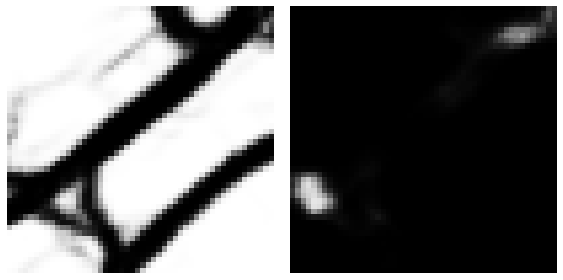

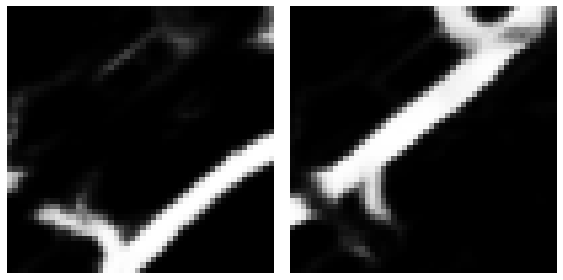

In [13]:
# we would like our probabilities to be constant along structures (ideally always 1!), but they are not:
imshow_pair(probs[0,0,400:450,300:350], probs[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,2,400:450,300:350], probs[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [14]:
perfect_logits = 100*torch.stack([(labels==0),(labels==1),(labels==2),(labels==3)],dim=1).float()
perfect_probs = torch.nn.Softmax(dim=1)(perfect_logits)

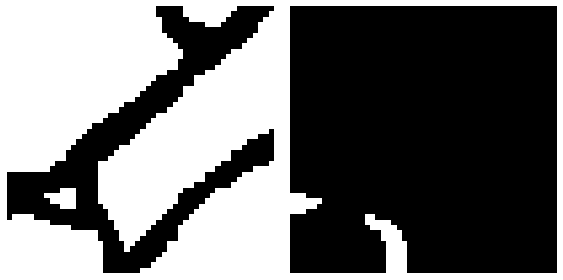

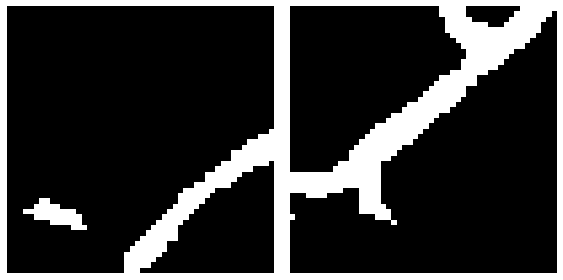

In [15]:
# this is the way ideal probabilities look
imshow_pair(perfect_probs[0,0,400:450,300:350], perfect_probs[0,1,400:450,300:350])
imshow_pair(perfect_probs[0,2,400:450,300:350], perfect_probs[0,3,400:450,300:350])

In [18]:
ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
error_map = torch.abs(probs-ignore_map.float()).le(0.5)

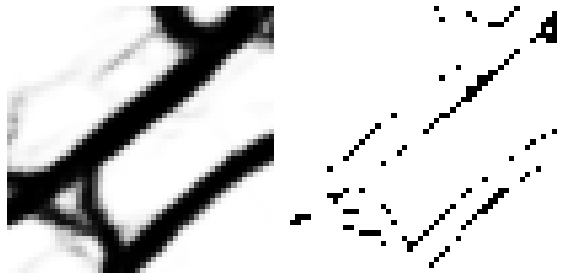

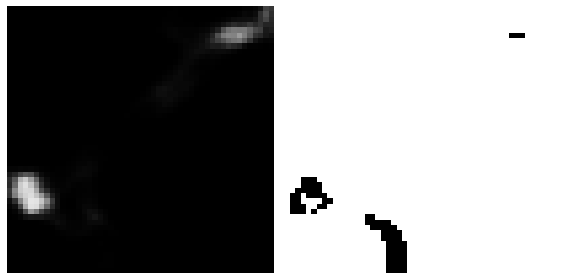

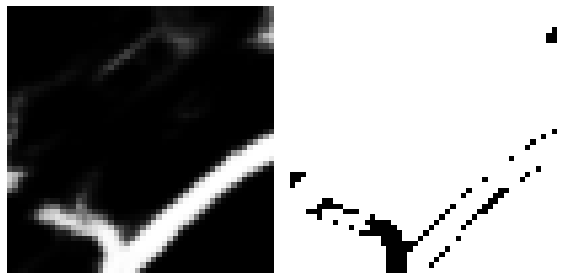

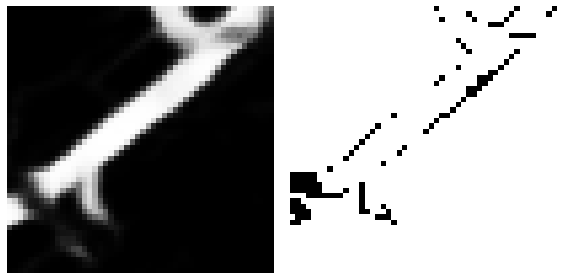

In [19]:
imshow_pair(probs[0,0,400:450,300:350], error_map[0,0,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,1,400:450,300:350], error_map[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,2,400:450,300:350], error_map[0,2,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,3,400:450,300:350], error_map[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

Let us start with left-to-right variations of intensity:

In [20]:
# row 1: bright to dark, row 2: dark to bright
x = torch.tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 1]).view(2, 5)
x

tensor([[1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1]])

In [21]:
torch.roll(x, shifts=-1, dims=-1) # xi,j+1

tensor([[1, 1, 0, 0, 1],
        [0, 0, 1, 1, 0]])

In [22]:
# xi,j - xi,j+1 (horizontal gradient)
# bright to dark: high pos values
# dark to bright: high neg values
x-torch.roll(x, shifts=-1, dims=-1)

tensor([[ 0,  0,  1,  0, -1],
        [ 0,  0, -1,  0,  1]])

In [23]:
torch.roll(x, shifts=1, dims=-1) # xi,j-1

tensor([[0, 1, 1, 1, 0],
        [1, 0, 0, 0, 1]])

In [24]:
# xi,j - xi,j-1 (horizontal gradient)
# bright to dark: high neg values
# dark to bright: high pos values
x-torch.roll(x, shifts=1, dims=-1)

tensor([[ 1,  0,  0, -1,  0],
        [-1,  0,  0,  1,  0]])

In [25]:
torch.abs(x-torch.roll(x, shifts=-1, dims=-1)), torch.abs(x-torch.roll(x, shifts=1, dims=-1))

(tensor([[0, 0, 1, 0, 1],
         [0, 0, 1, 0, 1]]),
 tensor([[1, 0, 0, 1, 0],
         [1, 0, 0, 1, 0]]))

In [26]:
# this gets us a high pos value in bright to dark and dark to bright jumps only
torch.max(x-torch.roll(x, shifts=-1, dims=-1), x-torch.roll(x, shifts=1, dims=-1))

tensor([[1, 0, 1, 0, 0],
        [0, 0, 0, 1, 1]])

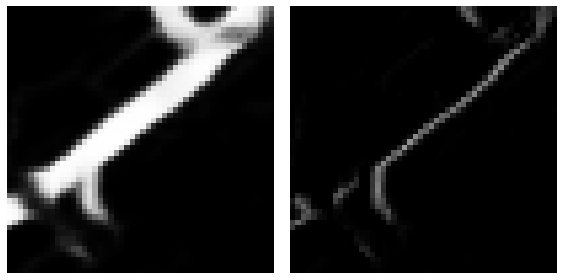

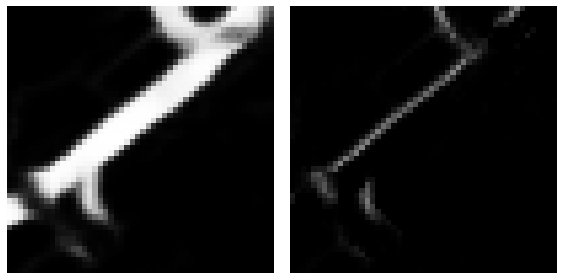

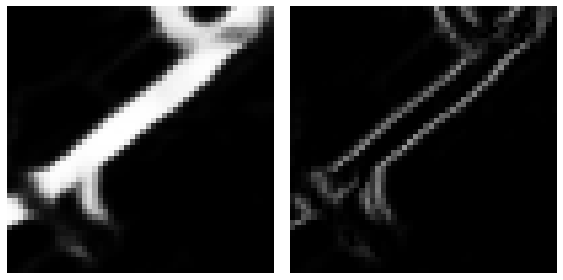

In [27]:
# xi,j - xi,j+1 (horizontal gradient, bright to dark: high pos values)
tv_r = torch.sub(probs, torch.roll(probs, shifts=-1, dims=-1)).detach()

# xi,j - xi,j-1 (horizontal gradient, dark to bright: high pos values)
tv_l = torch.sub(probs, torch.roll(probs, shifts=1, dims=-1)).detach() 

# combo: high pos value in bright to dark and dark to bright jumps only
tv_lr = torch.max(tv_r, tv_l)

imshow_pair(probs[0,3,400:450,300:350], tv_r[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,3,400:450,300:350], tv_l[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,3,400:450,300:350], tv_lr[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

Now, we don't want to have artificially high values in borders of labels, those are natural jumps. We need to discard gradient contributions from regions outside the vessel!

A simple way is to assign very high/low values outside the vessel so that gradient is disproportionately large, and then discard disproportionate values:

In [28]:
ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)

masked_probs_high = torch.nn.Softmax(dim=1)(logits).detach()
masked_probs_low = torch.nn.Softmax(dim=1)(logits).detach()
masked_probs_high[~ignore_map]=3 # assign high values outside labels
# masked_probs_low[~ignore_map]=-3 # assign low values outside labels

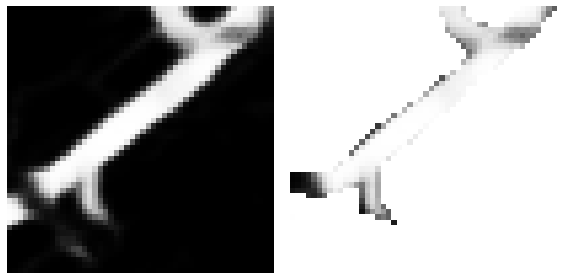

In [29]:
imshow_pair(probs[0,3,400:450,300:350], masked_probs_high[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

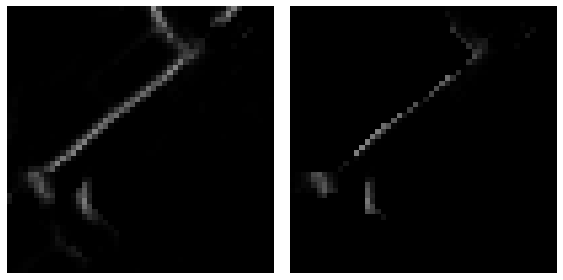

In [30]:
# xi,j - xi,j-1 (horizontal gradient, dark to bright: high pos values)
# using maked_probs_high, artificial jumps from dark to bright 
# are eliminated since all is bright now outside vessel
masked_tv_l = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=1, dims=-1)).detach() 
masked_tv_l[masked_tv_l>1]=0
imshow_pair(tv_l[0,3,400:450,300:350], masked_tv_l[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

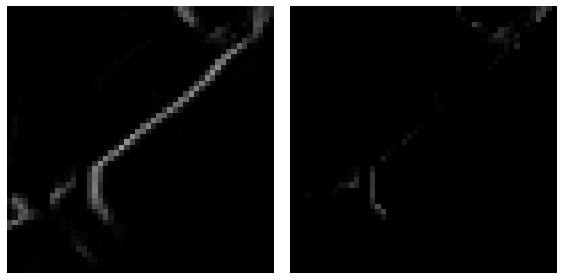

In [31]:
masked_tv_r = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=-1, dims=-1)).detach()
masked_tv_r[masked_tv_r>1]=0
imshow_pair(tv_r[0,3,400:450,300:350], masked_tv_r[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

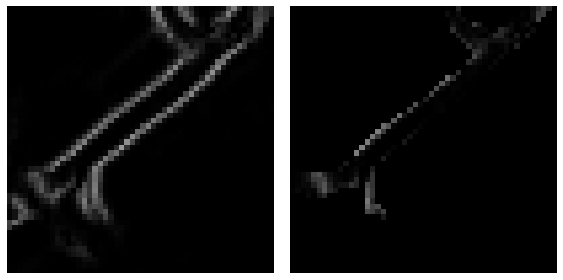

In [32]:
# combo: high pos value in bright to dark and dark to bright jumps only
masked_tv_lr = torch.max(masked_tv_r, masked_tv_l)
imshow_pair(tv_lr[0,3,400:450,300:350], masked_tv_lr[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [37]:
mm = torch.mul(masked_tv_lr, torch.abs(probs-ignore_map.float()))

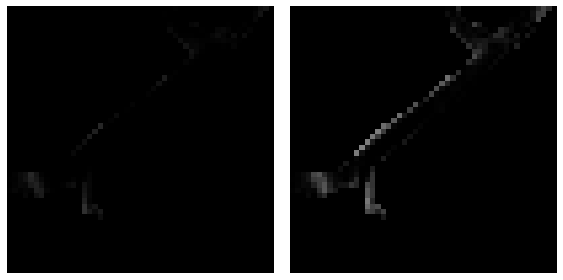

In [38]:
imshow_pair(mm[0,3,400:450,300:350], masked_tv_lr[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

### UP-DOWN

In [40]:
# col 1: bright to dark, col 2: dark to bright
x = torch.tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 1]).view(5, 2)
x

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]])

In [41]:
torch.roll(x, shifts=-1, dims=-2) # xi+1,j 

tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]])

In [42]:
# xi,j - xi+1,j  (vertical gradient)
# bright to dark: high pos values
# dark to bright: high neg values
x-torch.roll(x, shifts=-1, dims=-2)

tensor([[ 0,  0],
        [ 0,  0],
        [ 1, -1],
        [ 0,  0],
        [-1,  1]])

In [43]:
torch.roll(x, shifts=1, dims=-2) # xi-1,j

tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]])

In [44]:
# xi,j - xi-1,j (horizontal gradient)
# bright to dark: high neg values
# dark to bright: high pos values
x-torch.roll(x, shifts=1, dims=-2)

tensor([[ 1, -1],
        [ 0,  0],
        [ 0,  0],
        [-1,  1],
        [ 0,  0]])

In [45]:
# torch.abs(x-torch.roll(x, shifts=1, dims=-2)), torch.abs(x-x-torch.roll(x, shifts=1, dims=-2))

In [46]:
# this gets us a high pos value in bright to dark and dark to bright jumps only
torch.max(x-torch.roll(x, shifts=-1, dims=-2), x-torch.roll(x, shifts=1, dims=-2))

tensor([[1, 0],
        [0, 0],
        [1, 0],
        [0, 1],
        [0, 1]])

In [59]:
idx = 2

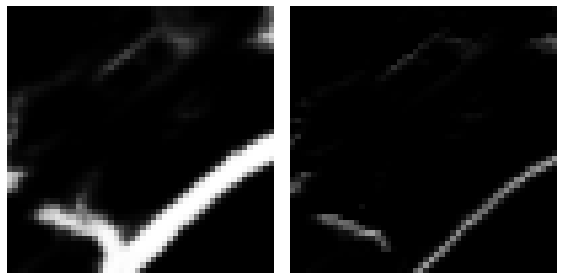

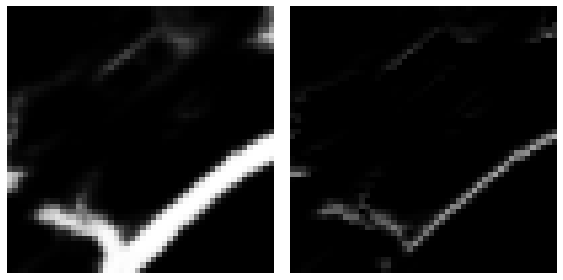

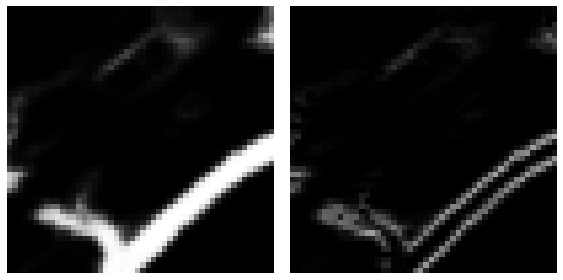

In [60]:
# xi,j - xi+1,j  (vertical gradient, bright to dark: high pos values)
tv_u = torch.sub(probs, torch.roll(probs, shifts=-1, dims=-2)).detach()

# xi,j - xi-1,j (vertical gradient, dark to bright: high pos values)
tv_d = torch.sub(probs, torch.roll(probs, shifts=1, dims=-2)).detach() 

# combo: high pos value in bright to dark and dark to bright jumps only
tv_ud = torch.max(tv_u, tv_d)

imshow_pair(probs[0,idx,400:450,300:350], tv_u[0,idx,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,idx,400:450,300:350], tv_d[0,idx,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,idx,400:450,300:350], tv_ud[0,idx,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

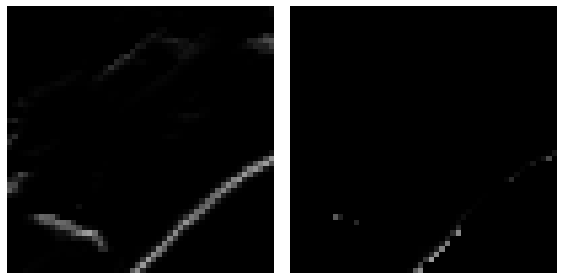

In [61]:
masked_tv_u = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=-1, dims=-2)).detach()
masked_tv_u[masked_tv_u>1]=0
imshow_pair(tv_u[0,idx,400:450,300:350], masked_tv_u[0,idx,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

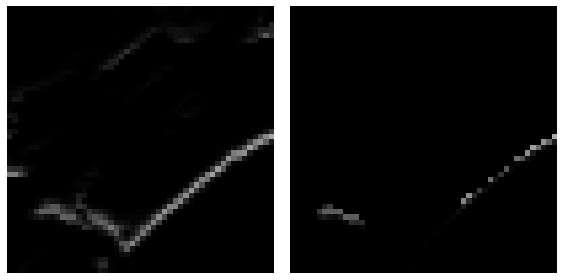

In [62]:
masked_tv_d = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=1, dims=-2)).detach() 
masked_tv_d[masked_tv_d>1]=0
imshow_pair(tv_d[0,idx,400:450,300:350], masked_tv_d[0,idx,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

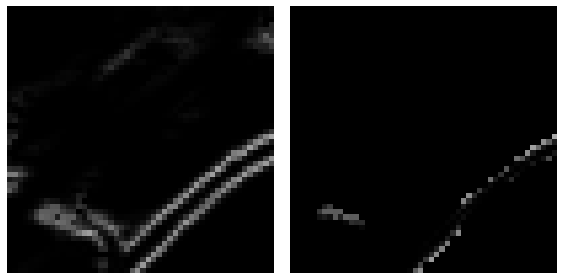

In [63]:
# combo: high pos value in bright to dark and dark to bright jumps only
masked_tv_ud = torch.max(masked_tv_u, masked_tv_d)
imshow_pair(tv_ud[0,idx,400:450,300:350], masked_tv_ud[0,idx,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [64]:
masked_tv_lr.shape, masked_tv_ud.shape

(torch.Size([2, 4, 512, 512]), torch.Size([2, 4, 512, 512]))

In [65]:
overall_tv = torch.mean(torch.stack([masked_tv_lr,masked_tv_ud], dim=0), dim=0)
overall_tv = torch.mul(overall_tv, torch.abs(probs-ignore_map.float()))

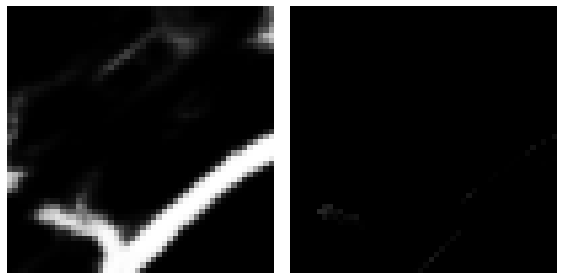

In [66]:
imshow_pair(probs[0,idx,400:450,300:350], overall_tv[0,idx,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [67]:
# Last step is to remove from TV all pixels that are not part of the structure:
masked_overall_tv = torch.mul(ignore_map, overall_tv)

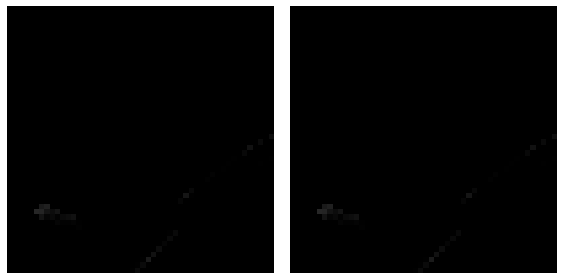

In [68]:
imshow_pair(overall_tv[0,idx,400:450,300:350], masked_overall_tv[0,idx,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
class MaskedTV(torch.nn.Module):
    def __init__(self, ignore_background=False, sqrt=False, reduction='mean'):
        super(MaskedTV, self).__init__()
        self.reduction = reduction
        self.sqrt = sqrt
        self.ignore_background = ignore_background

    def compute_tv(self, logits):

        preds = torch.nn.Softmax(dim=1)(logits)

        tv_l = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=3)))
        tv_r = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=3)))
        tv_lu = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, 1), dims=(2, 3))))
        tv_rd = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, -1), dims=(2, 3))))

        tv_u = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=2)))
        tv_d = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=2)))
        tv_ru = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, -1), dims=(2, 3))))
        tv_dl = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, 1), dims=(2, 3))))
        # take mean across orientations
        tv = torch.mean(torch.stack([tv_l, tv_r, tv_lu, tv_rd, tv_u, tv_d, tv_ru, tv_dl], dim=0), dim=0)

        return tv
    
    def compute_grad(self, labels):
        grads = []
        for j in range(4):
            tv_l = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=2)))
            tv_r = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=2)))
            tv_u = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=1)))
            tv_d = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=1)))
            # take max across orientations
            this_grad, _ = torch.max(torch.stack([tv_l, tv_r, tv_u, tv_d], dim=0), dim=0)
            grads.append(this_grad)

        grad = torch.stack(grads, dim=1)

        return grad
    def forward(self, logits, labels, **kwargs):
        # assumes logits is bs x n_classes H x W,
        #         labels is bs x H x W containing integer values in [0,...,n_classes-1]
        
        grad = self.compute_grad(labels)
        ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
        
        perfect_logits = 1000*torch.stack([(labels==0),(labels==1),(labels==2),(labels==3)],dim=1).float()
        tv = self.compute_tv(perfect_logits)
        masked_tv = torch.mul(tv, ignore_map)
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits))
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits)+1e-4)
        masked_tv = torch.mul(masked_tv, (grad==0))
        false_positives = (masked_tv!=0)
        
        
        tv = self.compute_tv(logits)
        masked_tv = torch.mul(tv, ignore_map)
        masked_tv[false_positives]=0
        
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits))
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits)+1e-4)
        masked_tv = torch.mul(masked_tv, (grad==0))
        
#         masked_tv[masked_tv==0.25]=0
        
        if self.ignore_background:
            masked_tv = masked_tv[:, 2:, ...]
            ignore_map = ignore_map[:, 2:, ...]
            
        if self.reduction == 'mean':  # 1 value for the entire batch
            mean_per_elem_per_class = (masked_tv.sum(dim=(-2, -1)) / ignore_map.sum(dim=(-2, -1)))
            return mean_per_elem_per_class.mean()
        elif self.reduction == 'none':  # n_classes values per element in batch
            return masked_tv
        else:
            sys.exit('not a valid reduction scheme')

We compute the total variation along the different structures, and we will penalize its value

In [54]:
probs = torch.nn.Softmax(dim=1)(logits).detach()

tv_l = torch.sub(probs, torch.roll(probs, shifts=1, dims=3)).detach()
tv_l[tv_l<0]=0
tv_r = torch.sub(probs, torch.roll(probs, shifts=-1, dims=3)).detach()
tv_r[tv_r<0]=0

tv_lr = torch.mean(torch.stack([tv_l, tv_r], dim=0), dim=0)

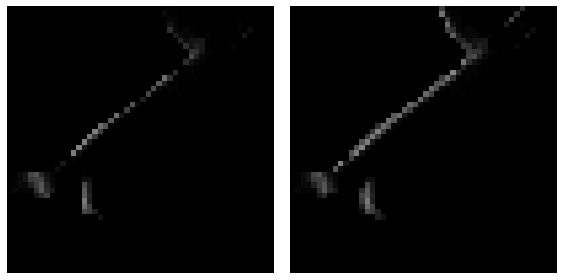

In [59]:
masked_tv_l1 = torch.sub(probs, torch.roll(masked_probs, shifts=1, dims=3)).detach()
masked_tv_l1[masked_tv_l1>1]=0
masked_tv_l1[masked_tv_l1<0]=0

masked_tv_l2 = torch.sub(masked_probs, torch.roll(probs, shifts=1, dims=3)).detach()
masked_tv_l2[masked_tv_l2>1]=0
masked_tv_l2[masked_tv_l2<0]=0

imshow_pair(masked_tv_l1[0,3,400:450,300:350], masked_tv_l2[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# masked_tv_r = torch.sub(probs, torch.roll(masked_probs, shifts=-1, dims=3)).detach()
# masked_tv_r[masked_tv_r<0]=0
# masked_tv_r[masked_tv_r>1]=0

# imshow_pair(masked_tv_l[0,3,400:450,300:350], masked_tv_r[0,3,400:450,300:350], 
# vmin1=0, vmax1=1, vmin2=0, vmax2=1)

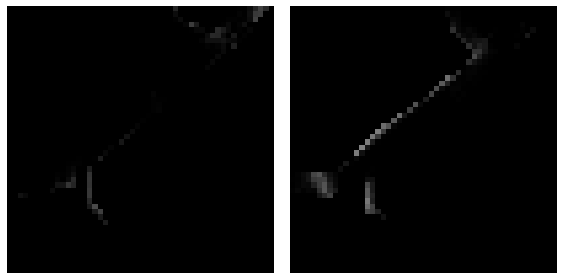

In [60]:
masked_tv_r1 = torch.sub(probs, torch.roll(masked_probs, shifts=-1, dims=3)).detach()
masked_tv_r1[masked_tv_r1>1]=0
masked_tv_r1[masked_tv_r1<0]=0

masked_tv_r2 = torch.sub(probs, torch.roll(masked_probs, shifts=1, dims=3)).detach()
masked_tv_r2[masked_tv_r2>1]=0
masked_tv_r2[masked_tv_r2<0]=0

imshow_pair(masked_tv_r1[0,3,400:450,300:350], masked_tv_r2[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# masked_tv_r = torch.sub(probs, torch.roll(masked_probs, shifts=-1, dims=3)).detach()
# masked_tv_r[masked_tv_r<0]=0
# masked_tv_r[masked_tv_r>1]=0

# imshow_pair(masked_tv_l[0,3,400:450,300:350], masked_tv_r[0,3,400:450,300:350], 
# vmin1=0, vmax1=1, vmin2=0, vmax2=1)

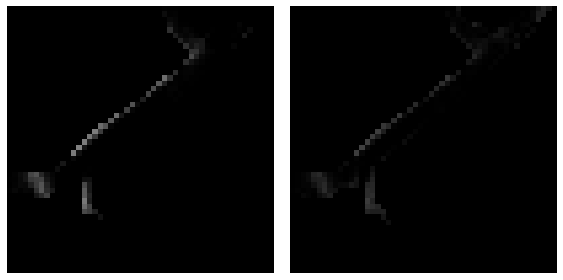

In [57]:
tv_lr = torch.mean(torch.stack([masked_tv_l, masked_tv_r], dim=0), dim=0)
imshow_pair(masked_tv_l[0,3,400:450,300:350], tv_lr[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

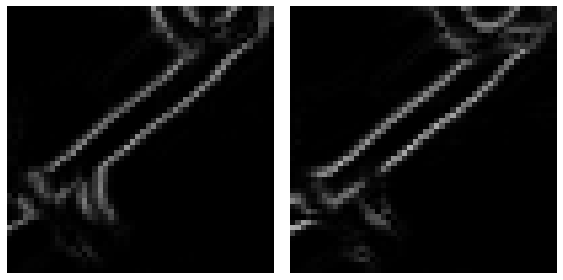

In [25]:
tv_l = torch.abs(torch.sub(probs, torch.roll(probs, shifts=1, dims=3))).detach()
tv_r = torch.abs(torch.sub(probs, torch.roll(probs, shifts=-1, dims=3))).detach()
tv_u = torch.abs(torch.sub(probs, torch.roll(probs, shifts=1, dims=2))).detach()
tv_d = torch.abs(torch.sub(probs, torch.roll(probs, shifts=-1, dims=2))).detach()

imshow_pair(tv_l[0,3,400:450,300:350], tv_u[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# imshow_pair(tv_u[0,2,400:450,300:350], tv_d[0,2,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [32]:
ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
masked_probs = torch.nn.Softmax(dim=1)(logits).detach()
masked_probs[~ignore_map]=3

masked_tv_l1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=1, dims=3))).detach()
masked_tv_l2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=1, dims=3))).detach()
masked_tv_l1[masked_tv_l1>1]=0
masked_tv_l2[masked_tv_l2>1]=0

masked_tv_r1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=-1, dims=3)))
masked_tv_r2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=-1, dims=3)))
masked_tv_r1[masked_tv_r1>1]=0
masked_tv_r2[masked_tv_r2>1]=0

# imshow_pair(tv_l[0,3,400:450,300:350], masked_tv_l1[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# imshow_pair(tv_l[0,3,400:450,300:350], masked_tv_l2[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

# imshow_pair(tv_r[0,3,400:450,300:350], masked_tv_r2[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# imshow_pair(tv_r[0,3,400:450,300:350], masked_tv_r1[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

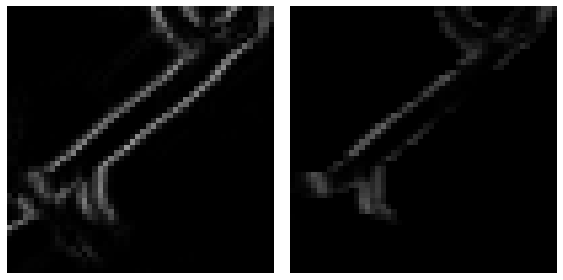

In [33]:
# masked_tv_lr = torch.min(masked_tv_l1, masked_tv_l2)
# masked_tv_lr = torch.min(masked_tv_lr, masked_tv_r1)
# masked_tv_lr = torch.min(masked_tv_lr, masked_tv_r2)
masked_tv_lr = torch.mean(torch.stack([masked_tv_l1, masked_tv_l2, masked_tv_r1, masked_tv_r2], dim=0), dim=0)

imshow_pair(tv_l[0,3,400:450,300:350], masked_tv_lr[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [36]:
ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
masked_probs = torch.nn.Softmax(dim=1)(logits).detach()
masked_probs[~ignore_map]=3

masked_tv_u1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=1, dims=2))).detach()
masked_tv_u2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=1, dims=2))).detach()
masked_tv_u1[masked_tv_u1>1]=0
masked_tv_u2[masked_tv_u2>1]=0

masked_tv_d1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=-1, dims=2)))
masked_tv_d2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=-1, dims=2)))
masked_tv_d1[masked_tv_d1>1]=0
masked_tv_d2[masked_tv_d2>1]=0

# imshow_pair(tv_u[0,3,400:450,300:350], masked_tv_u1[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# imshow_pair(tv_u[0,3,400:450,300:350], masked_tv_u2[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

# imshow_pair(tv_d[0,3,400:450,300:350], masked_tv_d2[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# imshow_pair(tv_d[0,3,400:450,300:350], masked_tv_d1[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

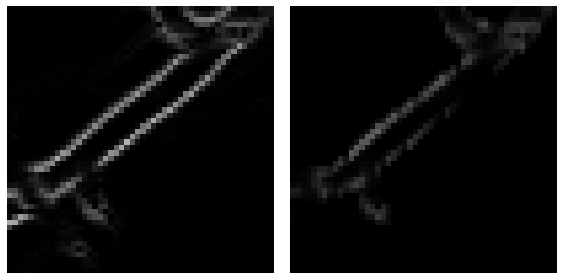

In [35]:
# masked_tv_lr = torch.min(masked_tv_l1, masked_tv_l2)
# masked_tv_lr = torch.min(masked_tv_lr, masked_tv_r1)
# masked_tv_lr = torch.min(masked_tv_lr, masked_tv_r2)
masked_tv_ud = torch.mean(torch.stack([masked_tv_u1, masked_tv_u2, masked_tv_d1, masked_tv_d2], dim=0), dim=0)

imshow_pair(tv_d[0,3,400:450,300:350], masked_tv_ud[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
masked_probs = torch.nn.Softmax(dim=1)(logits).detach()
masked_probs[~ignore_map]=2

masked_tv_l1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=1, dims=3))).detach()
masked_tv_r1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=-1, dims=3)))

masked_tv_l2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=1, dims=3))).detach()
masked_tv_r2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=-1, dims=3)))

masked_tv_u1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=1, dims=2))).detach()
masked_tv_u2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=1, dims=2))).detach()

masked_tv_d1 = torch.abs(torch.sub(probs, torch.roll(masked_probs, shifts=-1, dims=2)))
masked_tv_d2 = torch.abs(torch.sub(masked_probs, torch.roll(probs, shifts=-1, dims=2)))

masked_tv_l1[masked_tv_l1>1]=0
masked_tv_l2[masked_tv_l2>1]=0

masked_tv_r1[masked_tv_r1>1]=0
masked_tv_r2[masked_tv_r2>1]=0

masked_tv_u1[masked_tv_u1>1]=0
masked_tv_u2[masked_tv_u2>1]=0

masked_tv_d1[masked_tv_d1>1]=0
masked_tv_d2[masked_tv_d2>1]=0

# masked_tv_u1[masked_tv_u1>1]=0
# masked_tv_u2[masked_tv_u2>1]=0

# masked_tv_l = torch.min(masked_tv_l1, masked_tv_l2)
# masked_tv_l = torch.min(masked_tv_l, masked_tv_r1)
# masked_tv_l = torch.min(masked_tv_l, masked_tv_r2)

# masked_tv = torch.mean(torch.stack([masked_tv_l1, masked_tv_l2, masked_tv_r1, masked_tv_r2], dim=0), dim=0)
# masked_tv = torch.mul(masked_tv, ignore_map).detach()

In [ ]:
imshow_pair(tv_l[0,2,400:450,300:350], masked_tv_l1[0,2,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(tv_l[0,2,400:450,300:350], masked_tv_l2[0,2,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(tv_l[0,2,400:450,300:350], masked_tv_l[0,2,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
# imshow_pair(tv_u[0,2,400:450,300:350], masked_tv_u[0,2,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
def compute_tv(logits):

    probs = torch.nn.Softmax(dim=1)(logits)

    tv_l = torch.abs(torch.sub(probs, torch.roll(probs, shifts=1, dims=3)))
    tv_r = torch.abs(torch.sub(probs, torch.roll(probs, shifts=-1, dims=3)))
#     tv_lu = torch.abs(torch.sub(probs, torch.roll(probs, shifts=(1, 1), dims=(2, 3))))
#     tv_rd = torch.abs(torch.sub(probs, torch.roll(probs, shifts=(-1, -1), dims=(2, 3))))

    tv_u = torch.abs(torch.sub(probs, torch.roll(probs, shifts=1, dims=2)))
    tv_d = torch.abs(torch.sub(probs, torch.roll(probs, shifts=-1, dims=2)))
#     tv_ru = torch.abs(torch.sub(probs, torch.roll(probs, shifts=(1, -1), dims=(2, 3))))
#     tv_dl = torch.abs(torch.sub(probs, torch.roll(probs, shifts=(-1, 1), dims=(2, 3))))
    # take mean across orientations
#     tv = torch.mean(torch.stack([tv_l, tv_r, tv_lu, tv_rd, tv_u, tv_d, tv_ru, tv_dl], dim=0), dim=0)
    tv = torch.mean(torch.stack([tv_l, tv_r, tv_u, tv_d], dim=0), dim=0)
    return tv

In [ ]:
def compute_grad(labels):
    grads = []
    for j in range(4):
        tv_l = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=2)))
        tv_r = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=2)))
        tv_u = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=1)))
        tv_d = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=1)))
        # take max across orientations
        this_grad, _ = torch.max(torch.stack([tv_l, tv_r, tv_u, tv_d], dim=0), dim=0)
        grads.append(this_grad)
        
    grad = torch.stack(grads, dim=1)
    
    return grad

In [ ]:
# we will ignore TV loss on borders of labels
grad = compute_grad(labels)
imshow_pair(grad[0,0,400:450,300:350], grad[0,1,400:450,300:350])
imshow_pair(grad[0,2,400:450,300:350], grad[0,3,400:450,300:350])

In [ ]:
# we only care about tv where labels are positive
ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
imshow_pair(ignore_map[0,0,400:450,300:350], ignore_map[0,1,400:450,300:350])
imshow_pair(ignore_map[0,2,400:450,300:350], ignore_map[0,3,400:450,300:350])

In [ ]:
# this is the TV of our probabilities, which we would like to be constant (=0)
tv = compute_tv(logits).detach()
imshow_pair(tv[0,0,400:450,300:350], tv[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(tv[0,2,400:450,300:350], tv[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# this is the TV of perfect probabilities, which is only non-zero at gradients of structures
tv_perf = compute_tv(perfect_logits).detach()
imshow_pair(tv_perf[0,0,400:450,300:350], tv_perf[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(tv_perf[0,2,400:450,300:350], tv_perf[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# this ignores, for each channel, pixels that do not belong to the corresponding label, 
# only non-zero pixels here will be of interest
masked_tv = torch.mul(tv, ignore_map).detach()
imshow_pair(masked_tv[0,0,400:450,300:350], masked_tv[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv[0,2,400:450,300:350], masked_tv[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# the corresponding TV on perfect predictions should be all zeros unless at label gradients!
masked_tv_perf = torch.mul(tv_perf, ignore_map).detach()
imshow_pair(masked_tv_perf[0,0,400:450,300:350], masked_tv_perf[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv_perf[0,2,400:450,300:350], masked_tv_perf[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# we can actually discard pixels where the TV in perfect probs was non-zero, those are failure to compute grads
# at a good resolution
ignore_map2 = (masked_tv_perf==0)
imshow_pair(ignore_map2[0,0,400:450,300:350], ignore_map2[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(ignore_map2[0,2,400:450,300:350], ignore_map2[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# if we ignore those pixels with perfect probs, we should see all zeros now
masked_tv_perf = torch.mul(masked_tv_perf, ignore_map2).detach()
imshow_pair(masked_tv_perf[0,0,400:450,300:350], masked_tv_perf[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv_perf[0,2,400:450,300:350], masked_tv_perf[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# if we ignore those pixels with actual probs, we should discard hard pixels
masked_tv = torch.mul(masked_tv, ignore_map2).detach()
imshow_pair(masked_tv[0,0,400:450,300:350], masked_tv[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv[0,2,400:450,300:350], masked_tv[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

So those are the pixels that we would like to be zero! However, being zero alone does not promote good classification, only consistency. What if we divide by the probability itself? If he probability is close to zero, we get high numbers, but if it is close to one we get low numbers:

In [ ]:
w_masked_tv = torch.div(masked_tv, probs+1e-8)
imshow_pair(w_masked_tv[0,0,400:450,300:350], w_masked_tv[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(w_masked_tv[0,2,400:450,300:350], w_masked_tv[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

Now, that also penalizes incorrect predictions. Let us see if we get zeros with our perfect preds:

In [ ]:
w_masked_tv_perf = torch.div(masked_tv_perf, perfect_probs+1e-8)
imshow_pair(w_masked_tv_perf[0,0,400:450,300:350], w_masked_tv_perf[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(w_masked_tv_perf[0,2,400:450,300:350], w_masked_tv_perf[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

So we are happy now; let us compare the predictions with their penalty maps now:

In [ ]:
imshow_pair(perfect_probs[0,0,400:450,300:350], w_masked_tv[0,0,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,0,400:450,300:350], w_masked_tv[0,0,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,1,400:450,300:350], w_masked_tv[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,1,400:450,300:350], w_masked_tv[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,2,400:450,300:350], w_masked_tv[0,2,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,2,400:450,300:350], w_masked_tv[0,2,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,3,400:450,300:350], w_masked_tv[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,3,400:450,300:350], w_masked_tv[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

One thing we are not doing is penalizing errors outside structures (aka false positives). We could also add penalty there but only TV, so that they can nicely become all zero.

In [ ]:
ignore_map_FP = torch.stack([labels != 0, labels != 1, labels != 2, labels != 3], dim=1)
imshow_pair(ignore_map_FP[0,0,400:450,300:350], ignore_map_FP[0,1,400:450,300:350])
imshow_pair(ignore_map_FP[0,2,400:450,300:350], ignore_map_FP[0,3,400:450,300:350])

In [ ]:
# On those we want to compute TV alone, without dividing
masked_tv_FP = torch.mul(tv, ignore_map_FP).detach()
imshow_pair(masked_tv_FP[0,0,400:450,300:350], masked_tv_FP[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv_FP[0,2,400:450,300:350], masked_tv_FP[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# the corresponding TV on perfect predictions should be all zeros unless at label gradients!
masked_tv_perf_FP = torch.mul(tv_perf, ignore_map_FP).detach()
imshow_pair(masked_tv_perf_FP[0,0,400:450,300:350], masked_tv_perf_FP[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv_perf_FP[0,2,400:450,300:350], masked_tv_perf_FP[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# we can actually discard pixels where the TV in perfect probs was non-zero, those are failure to compute grads
# at a good resolution
ignore_map2_FP = (masked_tv_perf_FP==0)
imshow_pair(ignore_map2_FP[0,0,400:450,300:350], ignore_map2_FP[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(ignore_map2_FP[0,2,400:450,300:350], ignore_map2_FP[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# if we ignore those pixels with perfect probs, we should see all zeros now
masked_tv_perf_FP = torch.mul(masked_tv_perf_FP, ignore_map2_FP).detach()
imshow_pair(masked_tv_perf_FP[0,0,400:450,300:350], masked_tv_perf_FP[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv_perf_FP[0,2,400:450,300:350], masked_tv_perf_FP[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
# if we ignore those pixels with actual probs, we should discard hard pixels
masked_tv_FP = torch.mul(masked_tv_FP, ignore_map2_FP).detach()
imshow_pair(masked_tv_FP[0,0,400:450,300:350], masked_tv_FP[0,1,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(masked_tv_FP[0,2,400:450,300:350], masked_tv_FP[0,3,400:450,300:350], vmin1=0, vmax1=1, vmin2=0, vmax2=1)

So now we should also be penalizing False Positive TV

In [ ]:
imshow_pair(perfect_probs[0,0,400:450,300:350], masked_tv_FP[0,0,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,0,400:450,300:350], masked_tv_FP[0,0,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,1,400:450,300:350], masked_tv_FP[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,1,400:450,300:350], masked_tv_FP[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,2,400:450,300:350], masked_tv_FP[0,2,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,2,400:450,300:350], masked_tv_FP[0,2,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,3,400:450,300:350], masked_tv_FP[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,3,400:450,300:350], masked_tv_FP[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

So we are ready to build everything up into a loss:

In [ ]:
imshow_pair(probs[0,1,400:450,300:350],w_masked_tv[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(probs[0,2,400:450,300:350], w_masked_tv[0,2,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(probs[0,3,400:450,300:350],w_masked_tv[0,3,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(w_masked_tv[0,0,400:450,300:350], w_masked_tv[0,1,400:450,300:350], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)
imshow_pair(w_masked_tv[0,2,400:450,300:350], w_masked_tv[0,3,400:450,300:350],
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,idx,400:450,300:350].detach(), probs[0,idx,400:450,300:350].detach())

In [ ]:
imshow_pair(masked_tv[0,idx,400:450,300:350], masked_tv_perf[0,idx,400:450,300:350])

In [ ]:
imshow_pair(weighted_masked_tv[0,idx,400:450,300:350], weighted_masked_tv_perf[0,idx,400:450,300:350])

In [ ]:
masked_tv_no_grad = torch.mul(masked_tv, (grad==0)).detach()
masked_tv_no_grad_perf = torch.mul(masked_tv_perf, (grad==0)).detach()

weighted_masked_tv_no_grad = torch.mul(weighted_masked_tv, (grad==0)).detach()
weighted_masked_tv_no_grad_perf = torch.mul(weighted_masked_tv_perf, (grad==0)).detach()

In [ ]:
masked_tv_no_grad[0,3,400:450,300:350].mean(), masked_tv_no_grad_perf[0,3,400:450,300:350].mean()

In [ ]:
weighted_masked_tv_no_grad[0,idx,400:450,300:350].mean(), \
weighted_masked_tv_no_grad_perf[0,idx,400:450,300:350].mean()

In [ ]:
imshow_pair(masked_tv_no_grad[0,idx,400:450,300:350], masked_tv_no_grad_perf[0,idx,400:450,300:350], 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
imshow_pair(weighted_masked_tv_no_grad[0,idx,400:450,300:350], weighted_masked_tv_no_grad_perf[0,idx,400:450,300:350], 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
torch.unique(weighted_masked_tv_no_grad_perf[0,idx])

In [ ]:
weighted_masked_tv_no_grad_perf[weighted_masked_tv_no_grad_perf==0.125]=0
weighted_masked_tv_no_grad_perf[weighted_masked_tv_no_grad_perf==0.25]=0

In [ ]:
torch.unique(weighted_masked_tv_no_grad_perf[0,idx])

In [ ]:
class MaskedTV(torch.nn.Module):
    def __init__(self, ignore_background=False, sqrt=False, reduction='mean'):
        super(MaskedTV, self).__init__()
        self.reduction = reduction
        self.sqrt = sqrt
        self.ignore_background = ignore_background

    def compute_tv(self, logits):

        preds = torch.nn.Softmax(dim=1)(logits)

        tv_l = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=3)))
        tv_r = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=3)))
        tv_lu = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, 1), dims=(2, 3))))
        tv_rd = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, -1), dims=(2, 3))))

        tv_u = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=2)))
        tv_d = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=2)))
        tv_ru = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, -1), dims=(2, 3))))
        tv_dl = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, 1), dims=(2, 3))))
        # take mean across orientations
        tv = torch.mean(torch.stack([tv_l, tv_r, tv_lu, tv_rd, tv_u, tv_d, tv_ru, tv_dl], dim=0), dim=0)

        return tv
    
    def compute_grad(self, labels):
        grads = []
        for j in range(4):
            tv_l = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=2)))
            tv_r = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=2)))
            tv_u = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=1)))
            tv_d = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=1)))
            # take max across orientations
            this_grad, _ = torch.max(torch.stack([tv_l, tv_r, tv_u, tv_d], dim=0), dim=0)
            grads.append(this_grad)

        grad = torch.stack(grads, dim=1)

        return grad
    def forward(self, logits, labels, **kwargs):
        # assumes logits is bs x n_classes H x W,
        #         labels is bs x H x W containing integer values in [0,...,n_classes-1]
        
        grad = self.compute_grad(labels)
        ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
        
        perfect_logits = 1000*torch.stack([(labels==0),(labels==1),(labels==2),(labels==3)],dim=1).float()
        tv = self.compute_tv(perfect_logits)
        masked_tv = torch.mul(tv, ignore_map)
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits))
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits)+1e-4)
        masked_tv = torch.mul(masked_tv, (grad==0))
        false_positives = (masked_tv!=0)
        
        
        tv = self.compute_tv(logits)
        masked_tv = torch.mul(tv, ignore_map)
        masked_tv[false_positives]=0
        
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits))
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits)+1e-4)
        masked_tv = torch.mul(masked_tv, (grad==0))
        
#         masked_tv[masked_tv==0.25]=0
        
        if self.ignore_background:
            masked_tv = masked_tv[:, 2:, ...]
            ignore_map = ignore_map[:, 2:, ...]
            
        if self.reduction == 'mean':  # 1 value for the entire batch
            mean_per_elem_per_class = (masked_tv.sum(dim=(-2, -1)) / ignore_map.sum(dim=(-2, -1)))
            return mean_per_elem_per_class.mean()
        elif self.reduction == 'none':  # n_classes values per element in batch
            return masked_tv
        else:
            sys.exit('not a valid reduction scheme')

In [ ]:
criterion  = MaskedTV(reduction='none',ignore_background=False)

In [ ]:
tv_loss_perfect  = criterion(perfect_logits, labels)
tv_loss_perfect.mean().item(), tv_loss_perfect.max().item()

In [ ]:
tv_loss  = criterion(logits, labels)
tv_loss.mean().item(), tv_loss[0,0].max().item(), tv_loss[0,1].max().item(), \
tv_loss[0,2].max().item(), tv_loss[0,3].max().item()

In [ ]:
imshow_pair(tv_loss[0,0,400:450,300:350].detach(), tv_loss[0,1,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
imshow_pair(tv_loss[0,2,400:450,300:350].detach(), tv_loss[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,3,400:450,300:350], tv_loss_perfect[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
criterion  = MaskedTV(ignore_background=False)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()

In [ ]:
criterion  = MaskedTV(ignore_background=False, sqrt=True)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()

In [ ]:
criterion  = MaskedTV(ignore_background=True)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()